In [1]:
# analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style('darkgrid')
np.set_printoptions(precision=3)
warnings.filterwarnings("ignore")

# missings (imputer)
# from sklearn.impute import SimpleImputer, KNNImputer

# interacciones
from sklearn.preprocessing import PolynomialFeatures

# transformaciones
from sklearn.compose import ColumnTransformer
# - variab numéricas
from sklearn.preprocessing import RobustScaler # MinMaxScaler, StandardScaler, Normalizer, Binarizer 
# from sklearn.preprocessing import PowerTransformer, BoxCox
# - variab categ
from sklearn.preprocessing import OneHotEncoder # LabelEncoder, OrdinalEncoder

# feature selection
from sklearn.feature_selection import f_classif # chi2
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.feature_selection import RFE, RFECV
# from sklearn.decomposition import PCA

# algoritmos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier # red neuronal

# bagging
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier

# boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

# model selection
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.pipeline import Pipeline # make_pipeline
from sklearn.model_selection import GridSearchCV # RandomizedSearchCV
from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict, ParameterGrid

# Técnicas de evaluación
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, RocCurveDisplay

In [2]:
# semilla de aleatorización

seed = 99

### Cargar datos depurados

In [3]:
data = pd.read_csv('Datasets/datos_procesados.csv')

print(f'Número de filas: {data.shape[0]}, Númerode columnas:{data.shape[1]}')

Número de filas: 4687, Númerode columnas:24


In [4]:
# Separar en train y test
X_train = data[data['Dataset'] == 'train'].drop(['Dataset'], axis=1)
X_test = data[data['Dataset'] == 'test'].drop(['Dataset'], axis=1)

# variable objetivo (.pop elimina la col de X, que también es un paso necesario)
y_train = X_train.pop('Hazardous')
y_test = X_test.pop('Hazardous')

In [5]:
# SMOTE (remuestro de datos de entrenamiento desbalanceados)

# Probaremos a obtener el mejor modelo tanto con los train_data desbalanceados como balanceados con smote

categ_index = X_train.columns.get_loc('Orbit Uncertainity (categ)')

smote_nc = SMOTENC(categorical_features=[categ_index], # hay que indicarle cuál es la variab categ en el dataset que se va a transformar
             random_state=seed)

X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

## 3.b XGBoost

* **XGBoost** (EXPLICACIÓN --> statquest youtube)


### Opción 1: XGBoost con sklearn y xgboost

SKlearn no tiene funciones nativas para XGBoosting, pero se puede utilizar la función XGBClassifier() de la librería xgboost. Esta función es integrable con sklearn, en otras palabras, nos permite hacer xgboosting de la misma manera en que, por ej, RandomForestClassifier() permite hacer Random Forest, todo utilizando la forma de trabajo sklearn (ie la API de sklearn).

In [6]:
# 1ª etapa (with all features)

import time
start_time = time.time()

# Algoritmo a probar
model = xgb.XGBClassifier(objective='binary:logistic', # clasif binaria estándar
                          tree_method='gpu_hist', # habilita la GPU
                          booster='gbtree', # tmb podría ser dart o gblinear, pero lo haremos solo con gbtree
                          eval_metric='logloss', # loss_function a minimizar, por dfto para binary:logistic
                          max_depth=5,
                          random_state=seed)

# Definir variabs numéricas y categóricas
scaler_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categ_features = [feature for feature in X_train.columns if feature not in scaler_features]

# Column transformer
col_transformer = ColumnTransformer(
    [
    ('encoder', OneHotEncoder(drop=["3-9"]), ['Orbit Uncertainity (categ)']), # @@ necesario??
    ('scaler', RobustScaler(), scaler_features)
    ], remainder='passthrough')

# Definir instancia SMOTENC
categ_index = X_train.columns.get_loc('Orbit Uncertainity (categ)')
smote_nc = SMOTENC(categorical_features=[categ_index], # hay que indicarle cuál es la variab categ en el dataset que se va a transformar
             random_state=seed)

# Pipeline 1
pipe = Pipeline([
#         ('smote_nc', smote_nc), # quitarlo si class_weight='balanced'
        ('column_transform', col_transformer),
        ('polynomial', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)), # añadir interacciones
        ('algorithm', model)        
])

parametros = {
    "algorithm__eta": [0.1, 0.2, 0.3], # alias: learning_rate
    "algorithm__subsample": [0.5, 0.75, 1], # si 1, hace reemplazamiento
    "algorithm__colsample_bytree": [0.6, 0.8, 1], # selección aleatoria de variabs para construir cada árbol
    "algorithm__scale_pos_weight": [1, 3], # para desbalanceados
}
# Otros paráms:
# - gamma (alias min_split_loss): Umbral de reducción de pérdida para dividir un nodo
#   A mayor gamma, modelo más conservador (dfto gamma=0) probar 0.25??
# - lambda (alias reg_lambda) --> regularización tipo L2 Ridge (dfto=1) probar 2??
# - alpha (alias reg_alpha) --> regularización tipo L1 (dfto=0)


# Repeated cross_val (stratified)
# cv_technique = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_technique = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)

# combinamos todo
gsearch = GridSearchCV(estimator=pipe, cv=cv_technique, param_grid=parametros, scoring='f1') # (*) scoring='f1'

# buscamos el mejor modelo
### OJO: si usamos resampled, entonces saldrá scale_pos_weigth=3 pq desbalanceados.

grid_model = gsearch.fit(X_train, y_train) # sin resample
# grid_model = gsearch.fit(X_train_resampled, y_train_resampled) # con SMOTE resample

print("Best CV score:", grid_model.best_score_)

end_time = time.time()
print()
print("Tiempo de ejecución:", end_time - start_time, "segundos")

Best CV score: 0.9916014528309699

Tiempo de ejecución: 820.9688949584961 segundos


In [7]:
# Mejor estimador
grid_model.best_estimator_.named_steps['algorithm']

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eta=0.2, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

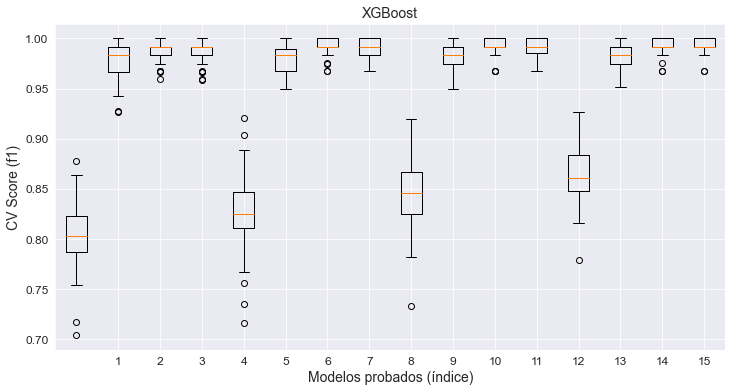


Tiempo de ejecución: 86.2114098072052 segundos


In [8]:
# 2ª etapa: boxplot para elegir el resto de paráms

# no podemos poner muchos paráms, o no veremos nada en los boxplots
# por eso aquí hay traer ya algunos paráms elegido

import time
start_time = time.time()

pipe_fs = Pipeline([
        ('column_transform', col_transformer),
        ('polynomial', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)), # añadir interacciones
        ('feature_selection', SelectKBest(score_func=f_classif)), # k = número de variabs a seleccionar
        ('algorithm', grid_model.best_estimator_.named_steps['algorithm'])        
]) # importante: meter el mejor algorithm obtenido antes

parametros_fs = {
    "feature_selection__k": [3,4,5,6],
    "algorithm__n_estimators": [10,20,30,40],
}

# Cambiar el formato de la malla de parámetros para poder usarlos en el bucle for
grid_params = list(ParameterGrid(parametros_fs)) # lista de diccionarios

cv_scores = []
for params in grid_params:
    # Configurar los parámetros del pipeline
    pipe_fs.set_params(**params)
    
    # Calcular los scores
    scores = cross_val_score(pipe_fs,
                             X_train, y_train, # X_train_resampled, y_train_resampled
                             cv=cv_technique, scoring='f1')
    cv_scores.append(scores)

# boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(cv_scores)
plt.title('XGBoost', fontsize=14)
plt.xlabel('Modelos probados (índice)', fontsize=14)
plt.ylabel('CV Score (f1)', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(range(2, len(cv_scores)+1), fontsize=12) # no consigo poner el xtick = 0
plt.show()

end_time = time.time()
print()
print("Tiempo de ejecución:", end_time - start_time, "segundos")

In [20]:
# Comparar mejores
print(grid_params[2])
print(grid_params[6])
print(grid_params[10])
print(grid_params[14])

{'algorithm__n_estimators': 10, 'feature_selection__k': 5}
{'algorithm__n_estimators': 20, 'feature_selection__k': 5}
{'algorithm__n_estimators': 30, 'feature_selection__k': 5}
{'algorithm__n_estimators': 40, 'feature_selection__k': 5}


In [10]:
# El mejor modelo es:
modelo_optimo = 2 # indicar nº óptimo

# Configura el pipeline con los parámetros deseados
selected_params = grid_params[modelo_optimo]
pipe_fs.set_params(**selected_params)

# Ajusta el modelo
selected_model = pipe_fs.fit(X_train, y_train)
selected_model

Pipeline(steps=[('column_transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(drop=['3-9']),
                                                  ['Orbit Uncertainity '
                                                   '(categ)']),
                                                 ('scaler', RobustScaler(),
                                                  ['Est Dia in M(max)',
                                                   'Relative Velocity km per '
                                                   'sec',
                                                   'Miss Dist.(Astronomical)',
                                                   'Minimum Orbit Intersection',
                                                   'Eccentricity',
                                                   'Semi Major Axis',
                                                   'Inclination',
                                                   'Asc Node Longitude...
                               eval_metric='logloss', feature_types=None,
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=10,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, ...))])

In [18]:
selected_model.named_steps['algorithm'].get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.8,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 10,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 99,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': 3,
 'subsample': 0.75,
 'tree_method': 'gpu_hist',
 'validate_parameters': None,
 'verbosity': None,
 'eta': 0.2}

In [11]:
# Variables seleccionadas:

ct_names = selected_model.named_steps['column_transform'].get_feature_names_out()
poly_names = selected_model.named_steps['polynomial'].get_feature_names_out(input_features=ct_names)
select_names = selected_model.named_steps['feature_selection'].get_feature_names_out(input_features=poly_names)

print(f"Las {len(select_names)} variabs seleccionadas son:")
[i for i in select_names]

Las 5 variabs seleccionadas son:


['scaler__Minimum Orbit Intersection',
 'scaler__Est Dia in M(max)_raiz2',
 'encoder__Orbit Uncertainity (categ)_0 scaler__Minimum Orbit Intersection_log',
 'scaler__Est Dia in M(max) scaler__Minimum Orbit Intersection_log',
 'scaler__Est Dia in M(max)_raiz2 scaler__Minimum Orbit Intersection_log']

El valor de f1 score es: 
 0.993
Otros estadísticos del test: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       787
           1       1.00      0.99      0.99       151

    accuracy                           1.00       938
   macro avg       1.00      0.99      1.00       938
weighted avg       1.00      1.00      1.00       938



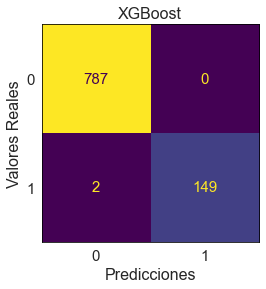

In [21]:
# Score y Confusion Matrix

# Evalúa el mejor modelo en tus datos de prueba
y_pred = selected_model.predict(X_test)

# Calcular la precisión de las predicciones en el conjunto de prueba
print(f"El valor de f1 score es: \n {f1_score(y_test, y_pred).round(3)}")
print(f"Otros estadísticos del test: \n {classification_report(y_test, y_pred)}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax, cmap='viridis', values_format='d', colorbar=False)
ax.grid(False) # Deshabilitar el grid de fondo

# plt.title('Matriz de confusión', fontsize=18) # Cambiar tamaño del título
ax.spines[['bottom','top','left','right']].set_color('black')
plt.title('XGBoost', fontsize=16)
plt.xlabel('Predicciones', fontsize=16)
plt.ylabel('Valores Reales', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
for text in ax.texts:
    text.set_fontsize(15)
plt.show()

## Importancia de las variabs

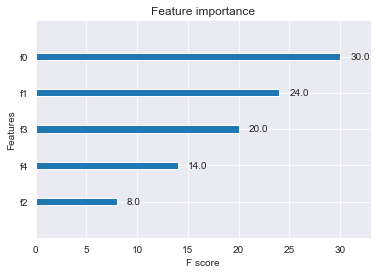

In [13]:
# opción 1: función de xgboost
from xgboost import plot_importance

plot_importance(selected_model.named_steps['algorithm'], max_num_features=20)
plt.show()

In [14]:
# opción 2: con sklearn

importances = selected_model.named_steps['algorithm'].feature_importances_
feature_names = select_names

# comprobar
print(len(importances))

5


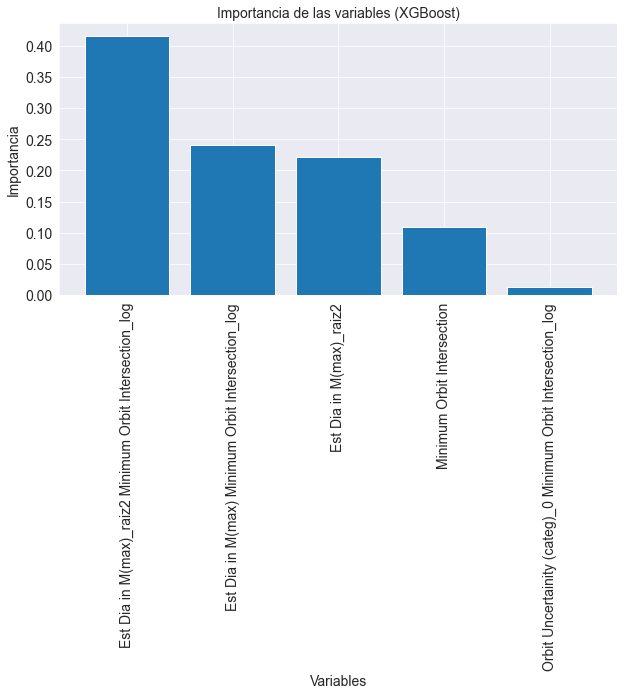

In [15]:
# Crear un dataframe con la información
df_importances = pd.DataFrame({'Variable': feature_names, 'Importancia': importances})

# Ordenar las variables por su importancia
df_importances = df_importances.sort_values('Importancia', ascending=False)

# (recortar el nombre de las variabs, sino es muy largo)
df_importances['Variable'] = df_importances['Variable'].replace(['scaler__', 'encoder__'], '', regex=True)

# Gráfico de barras
plt.figure(figsize=(10,5))
# Como son demasiadas variabs, mostramos solo las n mejores:
n = 10
plt.bar(df_importances['Variable'][0:n], df_importances['Importancia'][0:n])
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14) 
plt.title('Importancia de las variables (XGBoost)', fontsize=14) 
plt.xlabel('Variables', fontsize=14)
plt.ylabel('Importancia', fontsize=14)
plt.show()

In [22]:
import pickle

# Guarda los datos de puntuaciones
with open('cv_scores_model6.pkl', 'wb') as f:
    pickle.dump(cv_scores[modelo_optimo], f)

## Opción 2: XGBoost solo con xgboost

https://www.datacamp.com/tutorial/xgboost-in-python

In [16]:
# ### CODIGO INCOMPLETO

# # Lo primero sería pasar los datos a objetos xgb.DMatrix

# # xgb.DMatrix no admite categorías de tipo string. Los datos de X,y deben ser int, float, bool o category.
# # Opción 1: pasar a dummies antes de crear el objeto DMatrix
# # Opción 2: pasar la variab categórica al type de Pandas 'category'
# # (nota: en la varObj, xgboost solo acepta type numeric. Si nuestra y no fuera type 'int',
# # tendríamos que transformarla con por ej: # y_encoded = OrdinalEncoder().fit_transform(y)

# # La opción 1 es más fácil, pero por ser didácticos, practiquemos la opción 2:

# # Seleccionar variabs categ
# cats = X.select_dtypes(exclude=np.number).columns.tolist()
# # Convertir a type category
# for col in cats:
#    X[col] = X[col].astype('category')

# X.dtypes

In [17]:
# # Crear un objeto DMatrix de la librería xgboost
# dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
# dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

# # Especificar los parámetros del modelo
# param = {
#     'max_depth': 3,  # profundidad máxima de los árboles
#     'eta': 0.3,  # learning rate
#     'objective': 'multi:softmax',  # función objetivo: clasificación binaria
#     'num_class': 2  # número de clases
# }

# # Entrenar el modelo
# num_round = 10  # número de rondas de entrenamiento
# model = xgb.train(param, dtrain, num_round, )

# # Predicciones del test
# y_pred = model.predict(dtest)